In [2]:
# lib imports
import os
import time
import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import json
import joblib
import sklearn
from sklearn.impute import SimpleImputer
from scipy.stats.contingency import crosstab
import argparse
from sklearn import preprocessing

# custom imports
sys.path.append(os.path.expanduser('~'))
sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.process as proc
from functions.io import setup_logger, makedir
from functions.read_write import NpIntEncoder
from functions import FeatureEngine
from functions.plots_prediction import ethogram_plotter, CLtrajectory_plotter, transition_plotter
import functions.algebra as al

In [4]:
# %% SETTINGS
# set invalid (division by zero error) to ignore
np.seterr(invalid='ignore')
date = time.strftime("%Y%m%d")
datestr = time.strftime("%Y%m%d-%HH%MM")
newline = '\n'
sklearn.set_config(transform_output="pandas")


# %% Configuration
config = yaml.safe_load(open("config.yml", "r"))

config_batch_path = "config_batch.yml"
config_batch = yaml.safe_load(open(config_batch_path, "r"))
# %% INPUT
list_inpath_pattern = config_batch['Experiments'][config_batch['Settings']['run']]['conditions']

# recording
fps = config['settings']['fps']

# path
inpath = config['path']['predictions']
outpath = config['path']['analysis']
inpath_with_subfolders = config['path']['with subfolders']

# coloring and labels
cluster_color = config['cluster_color']
cluster_label = config['cluster_labels']
skip_already = config['settings']['skip_already']

In [95]:
all_cond_mean = pd.DataFrame([])
all_cond = pd.DataFrame([])
outpath = os.path.join(outpath,'CompareWTmec6')
for inpath_pattern in list_inpath_pattern:
    all_engine = {name:os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if inpath_pattern in os.path.basename(root) and name.endswith('prediction.json')}
    all_features_mean = pd.DataFrame([])
    
    for df_fname in all_engine.values():
        df = pd.read_json(df_fname, orient='split')
        df_mean = pd.DataFrame(df.mean(axis=0), columns=[os.path.basename(df_fname)]).T
        all_features_mean = pd.concat([all_features_mean,df_mean])
        
        df.index = pd.MultiIndex.from_product([[inpath_pattern], df.index])
        all_cond = pd.concat([all_cond, df.rolling(150).mean()[::30]])
        
        
    all_features_mean.index = pd.MultiIndex.from_product([[inpath_pattern], all_features_mean.index])
    scaler = preprocessing.RobustScaler()
    df_scaled = scaler.fit_transform(all_features_mean)
    df_scaled = pd.DataFrame(df_scaled)
    
    all_cond_mean = pd.concat([all_cond_mean, all_features_mean])
all_cond_mean

area      rate  \
L147    L147_240523_L147_results_41_prediction.json   526.550659  2.045296   
        L147_240523_L147_results_1_prediction.json    561.867160  1.592359   
        L147_240523_L147_results_4_prediction.json    523.583390  2.415749   
        L147_240523_L147_results_5_prediction.json    548.467859  2.751588   
        L147_240523_L147_results_8_prediction.json    587.651534  1.852328   
...                                                          ...       ...   
L176org L176_240502_L176_results_164_prediction.json  431.686919  2.033369   
        L176_240502_L176_results_5_prediction.json    588.807591  1.722430   
        L176_240502_L176_results_34_prediction.json   632.363153  2.155144   
        L176_240502_L176_results_28_prediction.json   627.337279  0.868112   
        L176_240502_L176_results_38_prediction.json   606.907890  0.997313   

                                                      negskew_clean  \
L147    L147_240523_L147_results_41_prediction.json   -1.663730e-03   
        L147_240523_L147_results_1_prediction.json    -4.044555e-04   
        L147_240523_L147_results_4_prediction.json    -1.979038e-04   
        L147_240523_L147_results_5_prediction.json     6.207598e-07   
        L147_240523_L147_results_8_prediction.json     2.684722e-06   
...                                                             ...   
L176org L176_240502_L176_results_164_prediction.json  -2.099395e-03   
        L176_240502_L176_results_5_prediction.json    -1.051077e-03   
        L176_240502_L176_results_34_prediction.json    2.718118e-05   
        L176_240502_L176_results_28_prediction.json    5.276940e-06   
        L176_240502_L176_results_38_prediction.json    1.931234e-06   

                                                      tip2cm_arccos  \
L147    L147_240523_L147_results_41_prediction.json        1.476293   
        L147_240523_L147_results_1_prediction.json         1.433365   
        L147_240523_L147_results_4_prediction.json         1.262481   
        L147_240523_L147_results_5_prediction.json         1.437902   
        L147_240523_L147_results_8_prediction.json         1.509170   
...                                                             ...   
L176org L176_240502_L176_results_164_prediction.json            NaN   
        L176_240502_L176_results_5_prediction.json              NaN   
        L176_240502_L176_results_34_prediction.json             NaN   
        L176_240502_L176_results_28_prediction.json             NaN   
        L176_240502_L176_results_38_prediction.json             NaN   

                                                      tip2back_arccos  \
L147    L147_240523_L147_results_41_prediction.json          0.235356   
        L147_240523_L147_results_1_prediction.json           0.220895   
        L147_240523_L147_results_4_prediction.json           0.302460   
        L147_240523_L147_results_5_prediction.json           0.329728   
        L147_240523_L147_results_8_prediction.json           0.230301   
...                                                               ...   
L176org L176_240502_L176_results_164_prediction.json              NaN   
        L176_240502_L176_results_5_prediction.json                NaN   
        L176_240502_L176_results_34_prediction.json               NaN   
        L176_240502_L176_results_28_prediction.json               NaN   
        L176_240502_L176_results_38_prediction.json               NaN   

                                                      cl2cl_arccos_dt30  \
L147    L147_240523_L147_results_41_prediction.json            0.335832   
        L147_240523_L147_results_1_prediction.json             0.266091   
        L147_240523_L147_results_4_prediction.json             0.435200   
        L147_240523_L147_results_5_prediction.json             0.260509   
        L147_240523_L147_results_8_prediction.json             0.316016   
...                                                                 ...   
L176org L176_24

In [40]:
L147_velo = all_cond.loc['L147','velocity_dt60']
L176scaled_velo = all_cond.loc['L176scaled','velocity_dt60']
L176org_velo = all_cond.loc['L176org','velocity_dt60']

L147_y = all_cond.loc['L147','prediction']
L176scaled_y = all_cond.loc['L176scaled','prediction']
L176org_y = all_cond.loc['L176org','prediction']

/tmp/ipykernel_42681/208377729.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  L147_velo = all_cond.loc['L147','velocity_dt60']
/tmp/ipykernel_42681/208377729.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  L176scaled_velo = all_cond.loc['L176scaled','velocity_dt60']
/tmp/ipykernel_42681/208377729.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  L176org_velo = all_cond.loc['L176org','velocity_dt60']
/tmp/ipykernel_42681/208377729.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  L147_y = all_cond.loc['L147','prediction']
/tmp/ipykernel_42681/208377729.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  L176scaled_y = all_cond.loc['L176scaled','prediction']
/tmp/ipykernel_42681/208377729.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  L176org_y = all_cond.loc['L176org','prediction']


In [36]:
pd.DataFrame([L147_velo.describe(), L176org_velo.describe(), L176scaled_velo.describe()], index=['L147', 'L176scaled', 'L176org']) 

,count,mean,std,min,25%,50%,75%,max
L147,6064.0,30.151305,30.737564,0.196365,5.216312,20.466864,45.622150,195.158516
L176scaled,3314.0,22.040745,23.243501,0.150122,3.577472,13.252097,33.955147,133.829452
L176org,3338.0,29.346245,30.893493,0.200054,4.819526,17.762771,45.209704,178.342449


In [97]:
train_velo = pd.read_csv('/gpfs/soma_fs/home/boeger/PpaPred_data/trainingset-velocity_dt60.csv')['velocity_dt60']
train_velo

0         1.704301
1         4.716690
2         3.503671
3         4.083320
4         4.292141
           ...    
22583    50.266373
22584    46.694986
22585    42.461434
22586    44.796118
22587    56.275500
Name: velocity_dt60, Length: 22588, dtype: float64

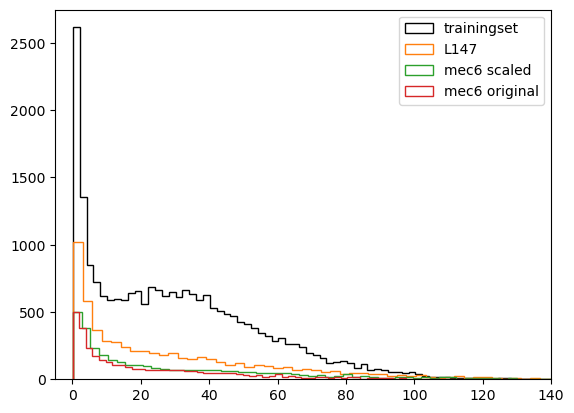

In [98]:
#for c in [0,1]:
plt.hist(train_velo, bins=70, histtype='step', label='trainingset', ec='k')
plt.hist(L147_velo, bins=70, histtype='step', label='L147')
plt.hist(L176scaled_velo, bins=70, histtype='step', label='mec6 scaled')
plt.hist(L176org_velo, bins=70, histtype='step',  label='mec6 original')
plt.xlim(-5,140);
plt.legend()

In [140]:
L147_hist, rng = np.histogram(L147_velo, 150,(0,150))
L147_cumhist = np.cumsum(L147_hist)
L176o_hist, _ = np.histogram(L176org_velo, 150,(0,150))
L176o_cumhist = np.cumsum(L147_hist)
train_hist, _ = np.histogram(train_velo, 150,(0,150))
train_cumhist = np.cumsum(train_hist)

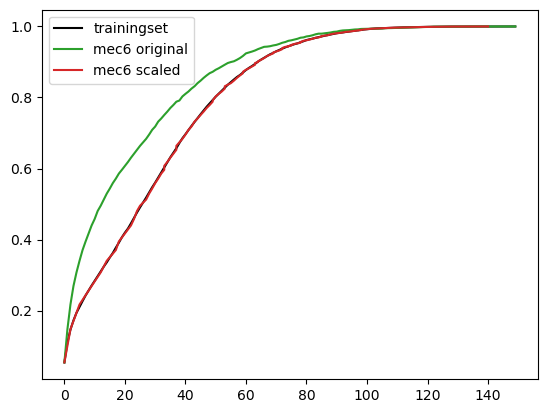

In [159]:
train_pdf = train_hist/np.sum(train_hist)
train_cumpdf = np.cumsum(train_pdf)
L176o_pdf = L176o_hist/np.sum(L176o_hist)
L176o_cumpdf = np.cumsum(L176o_pdf)

transform_indices = pd.DataFrame(abs(train_cumpdf - L176o_cumpdf[:, np.newaxis])).T
transform_indices = transform_indices.idxmin(axis=0).values

plt.plot(train_cumpdf, c='k', label='trainingset')
plt.plot(L176o_cumpdf, alpha=0)
plt.plot(L176o_cumpdf, alpha=0)
plt.plot(L176o_cumpdf, label='mec6 original')
plt.plot(transform_indices, L176o_cumpdf, label='mec6 scaled')
plt.legend()

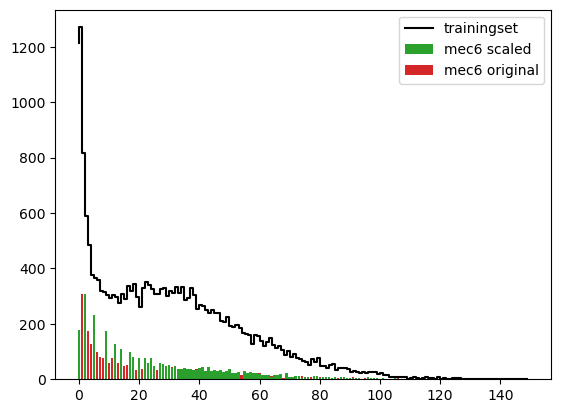

In [154]:
plt.step(rng[:-1],train_hist, color='k', label='trainingset')
plt.bar(rng[:-1],L147_hist, alpha = 0,)
plt.bar(rng[:-1],L147_hist, alpha = 0,)
plt.bar(transform_indices,L176o_hist, label='mec6 scaled', zorder=2)
plt.bar(rng[:-1],L176o_hist, label='mec6 original')
plt.legend()

In [41]:
df_basecols = df.columns.drop(df.filter(regex='cwt|maxfreq').columns)
df_maxfreqcols = df.filter(regex='maxfreq').columns

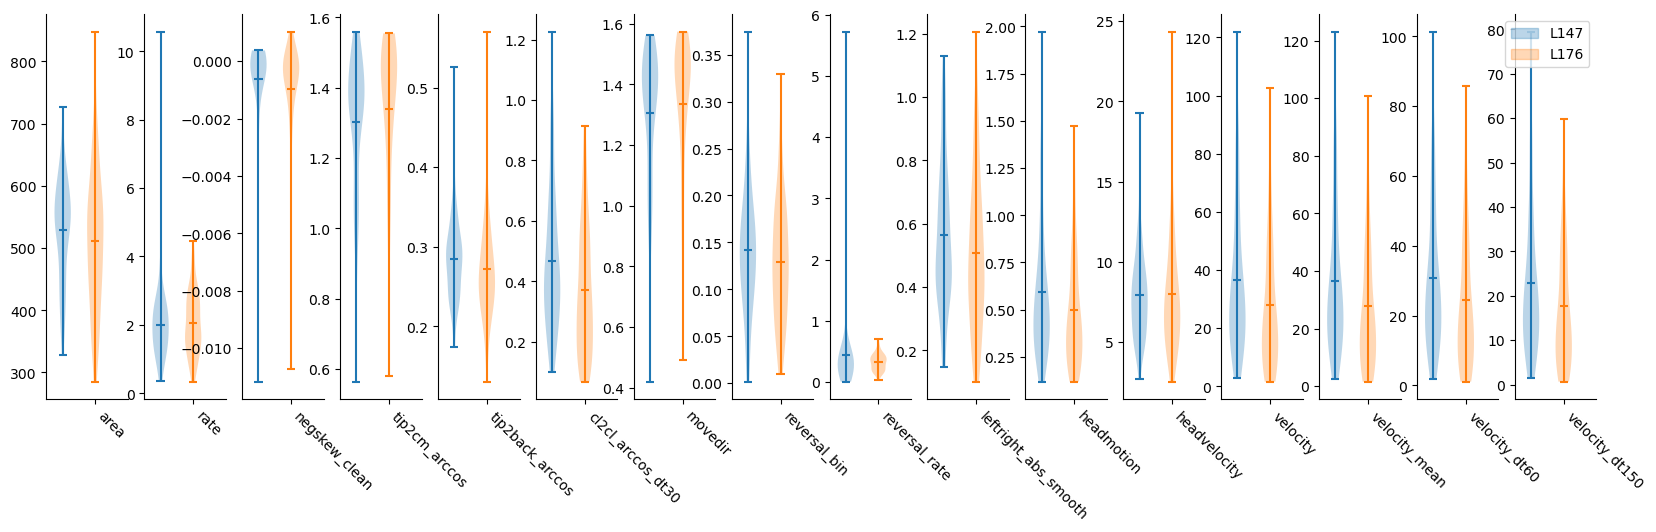

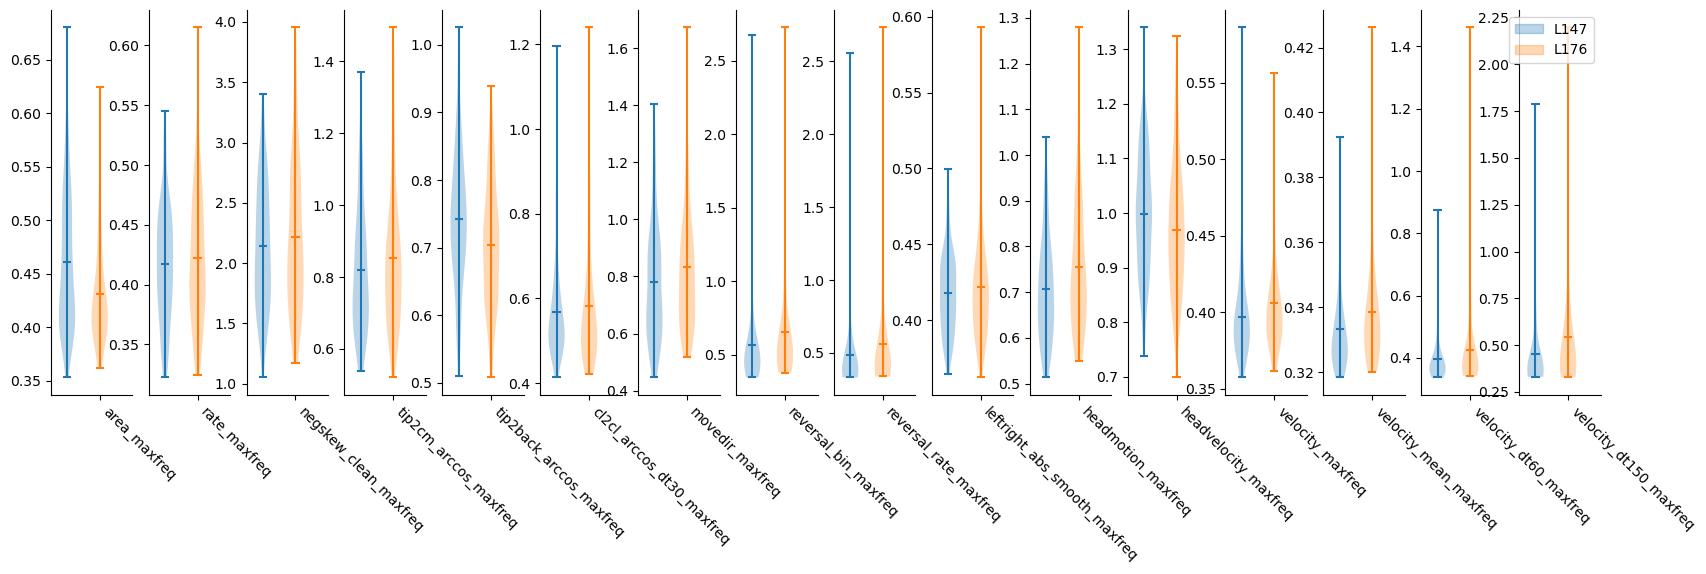

In [42]:
import matplotlib.patches as mpatches
for ftype, f_cols in {'Base': df_basecols, 'Maxfreq':df_maxfreqcols}.items():
    fig, axs = plt.subplots(1, len(f_cols), figsize=(20,5))
    labels = []
    for j, pat in enumerate(['L147', 'L176']):
        for i, col in enumerate(f_cols):
            violin = axs[i].violinplot(all_cond_mean.iloc[all_cond_mean.index.get_level_values(0) == pat][col].dropna(), positions=[j], showmeans=True)
            axs[i].set_xticks([1])
            axs[i].set_xticklabels([col], rotation=-45, ha='left')
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            axs[i].set_xlim(-.5,2)
        labels.append((mpatches.Patch(color = violin["bodies"][0].get_facecolor()[0]), pat))
    plt.legend(*zip(*labels))
    plt.savefig(os.path.join('/gpfs/soma_fs/home/boeger/PpaPred/temp/', f'feature{ftype}_violin.png'))
    plt.show()

In [ ]:
for ftype, f_cols in {'Base': df_basecols, 'Maxfreq':df_maxfreqcols}.items():
    fig, axs = plt.subplots(1, len(f_cols), figsize=(4*len(f_cols),4), sharex=True)
    for i, col in enumerate(f_cols):
        for j, pat in enumerate(['L147', 'L176']):
            _df = all_cond_mean.iloc[all_cond_mean.index.get_level_values(0) == pat]
            axs[i].scatter(_df['velocity_dt60'], _df[col], label=pat)
            axs[i].set_xlabel('velocity dt60')
            axs[i].set_title(col)
    plt.legend()
    plt.savefig(os.path.join('/gpfs/soma_fs/home/boeger/PpaPred/temp/', f'feature{ftype}_veloCorr_mean.png'))
    plt.show()

In [ ]:
for ftype, f_cols in {'Base': df_basecols, 'Maxfreq':df_maxfreqcols}.items():
    fig, axs = plt.subplots(4, len(f_cols), figsize=(4*len(f_cols),8), sharex=True, sharey='col')
    _color = ['tab:blue', 'tab:orange']
    for i, col in enumerate(f_cols):
        for j, pat in enumerate(['L147', 'L176']):
            _df = all_cond.iloc[all_cond.index.get_level_values(0) == pat]
            axs[j,i].scatter(_df['velocity_dt60'], _df[col], alpha=.1, label=pat, c=_color[j])
            axs[2,i].scatter(_df['velocity_dt60'], _df[col], alpha=.1, label=pat, c=_color[j])
            axs[3,i].scatter(_df['velocity_dt60'], _df[col], alpha=.1, label=pat, c=_color[j], zorder=2-j)
        axs[-1,i].set_xlabel('velocity_dt60')
        axs[0,i].set_title(col)
    plt.legend()
    plt.savefig(os.path.join('/gpfs/soma_fs/home/boeger/PpaPred/temp/', f'feature{ftype}_veloCorr_5secRes.png'))
    plt.show()

In [ ]:
count = 0
for k, CL in CLines.items():
    XY = XYs[k]
    PG = pd.read_json(all_engine[k.split('.')[0]+'_features.json'], orient='split')
    if count == 8:
        break
    count += 1

In [ ]:
adjustCL = (CL-np.nanmean(CL)) + np.repeat(XY.reshape(XY.shape[0],1, XY.shape[1]), CL.shape[1], axis=1)
# nosetip vs cm over time
_, tip2cm_arccos, _ = al.AngleLen(adjustCL, XY, hypotenuse = "v1", over="space", v1_args=dict(diffindex=[5,0]))
# anterior vs posterior part
_, tip2back_arccos, _ = al.AngleLen(adjustCL, adjustCL, hypotenuse = "v1", over="space", v2_over='space', v1_args=dict(diffindex=[40,10]),v2_args=dict(diffindex=[-10,60]))
# cm vs cm over time
_, cl2cl_arccos_dt30, _ = al.AngleLen(adjustCL, hypotenuse = "v1", over="space", v1_args=dict(diffindex=[-10,10]), v2_diff=30)

# pharynx vs cm over time
_, movedir, _ = al.AngleLen(adjustCL, XY, hypotenuse = "v1", over='space', v1_args=dict(diffindex=[-10,10]))
reversal_bin = np.where(pd.DataFrame(movedir).rolling(10).mean() >= np.deg2rad(120), 1, 0)
reversal_events = np.clip(np.diff(reversal_bin, axis=0), 0, 1)
reversal_rate = pd.Series(reversal_events.squeeze()).rolling(30, center=True).apply(lambda w: np.mean(w)*30)

# assume that v2 (cm vector) is hypotenuse, makes sideways headmotion vector more realistic
# pharynx vs cm over time, with sin calculated
headmotion, leftright, _ = al.AngleLen(adjustCL, XY, hypotenuse = "v2", over='space', v2_args=dict(diff_step=1), angletype=np.arcsin)
headvelocity = abs(headmotion[:-1] - headmotion[1:])/(1/30)
leftright_abs_smooth = abs(pd.DataFrame(leftright).rolling(30).mean())


In [ ]:
PG.columns

In [ ]:
def CLtrajectory_plotter(CLine, XY, cluster_color=['k'], cluster_label=[0], y = None, fn='', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    
    adjustCL = (CLine-np.nanmean(CLine))+np.repeat(XY.reshape(XY.shape[0],1,XY.shape[1]), CLine.shape[1], axis=1)# fits better than subtracting 50
    adjustXY = XY-np.nanmean(XY, axis=0)
    if y is not None:
        legend_elements = [Line2D([0], [0],color=cluster_color[i], label=cluster_label [i]) for i in cluster_label]
        for l in np.unique(y).astype(int):
            il = np.where(y == l)[0]
            ax.plot(*adjustCL[il].T, c=cluster_color[l], alpha = 0.1)
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1))
    else:
        ax.plot(*adjustCL.T, c=cluster_color[0], alpha = 0.1)
    ax.set_title(fn)
    ax.axis('equal')
    return fig

In [ ]:
CLtrajectory_plotter(CL, XY, figsize=(5,5));
plt.scatter(*pd.DataFrame(XY).dropna().iloc[0], marker='s', c='green', zorder=5)
plt.scatter(XY[::500,0],XY[::500,1], marker='.', c=range(len(XY[::500,0])), cmap='viridis', zorder=5)
plt.axis('equal')
plt.show();

In [ ]:
plt.plot(PG.velocity_dt60)
plt.show();

In [ ]:
plt.plot(pd.DataFrame(headvelocity).rolling(30).mean())
#plt.plot(PG.reversal_bin)
plt.show();

In [ ]:
cmap = plt.get_cmap('winter')
line_colors = cmap(pd.DataFrame(reversal_bin).rolling(2).mean())
plt.scatter(XY[-len(pd.DataFrame(reversal_bin)):,0], XY[-len(pd.DataFrame(reversal_bin)):,1], c=line_colors)
plt.axis('equal')
plt.show();

In [ ]:
def unitvector(xyarray, diff_step = 1):
    """
    Computes unit vectors and vector lengths from a 2D array of coordinates.
    
    Args:
        xyarray (np.ndarray): Input array of 2D coordinates (shape: [n_points, 2]).
    
    Returns:
        tuple: A tuple containing:
            - unit_vec (np.ndarray): Unit vectors corresponding to each coordinate.
            - vlen (np.ndarray): Vector lengths for each coordinate.
            - base (np.ndarray): Differences between consecutive coordinates.
    """
    base = xyarray[diff_step:] - xyarray[:-diff_step]
    vlen = np.linalg.norm(base, axis = 1).reshape(base.shape[0],1)
    unit_vec = np.divide(base,vlen)
    unit_vec = np.nan_to_num(unit_vec)
    return unit_vec, vlen/diff_step, base

def unitvector_space(xyarray, diffindex=[0,-1]):
    """
    Computes unit vectors and vector lengths for a given array of 2D points at a defined index.

    Args:
        xyarray (numpy.ndarray): A 2D array containing point coordinates.
        diffindex (list, optional): Indices for points to compute base vector from (default: [0, -1]).

    Returns:
        numpy.ndarray: Array of unit vectors.
        numpy.ndarray: Array of vector lengths.
        numpy.ndarray: Base vectors.
    """
    base = xyarray[:,diffindex[1]]-xyarray[:,diffindex[0]]
    vlen = np.linalg.norm(base, axis = 1).reshape(base.shape[0],1)
    unit_vec = np.divide(base,vlen)
    unit_vec = np.nan_to_num(unit_vec)
    return unit_vec, vlen, base


def AngleLen (v1, v2=None, hypotenuse = "v1", over="frames", v2_over = 'frames', v1_args={}, v2_args={}, v2_diff = 1, angletype=np.arccos):
    """
    Computes the length of the difference vector and the angle between two vectors.

    Args:
        v1 (numpy.ndarray): First vector (with 2D coordinates).
        v2 (numpy.ndarray, optional): Second vector (default: None).
        hypotenuse (str, optional): Determines which vector's length to use as the hypotenuse (default: "v1").
        over (str, optional): Specifies whether to compute over "frames" or "space" (default: "frames").
        **args: Additional arguments for unit vector computation, only applicable if over = "space".

    Returns:
        numpy.ndarray: Length of the difference vector.
        numpy.ndarray: Angle (in radians) between v1 and v2.
        numpy.ndarray: Difference vector (base vector).
    """
    func_dict = {'frames': unitvector,
                 'space': unitvector_space}
    
    v1_unitfunc = func_dict[over]
    v2_unitfunc = func_dict[v2_over]  
    v1_unit, v1_len, v1_diff = v1_unitfunc(v1,**v1_args)
    if not v2 is None:
        v2_unit, v2_len, v1_diff = v2_unitfunc(v2, **v2_args)
    else:
        v2_unit, v2_len, v1_diff = v1_unit[v2_diff:], v1_len[v2_diff:], v1_diff[v2_diff:]
    
    hyp = {"v1":v1_len, "v2":v2_len}
    hypo_len = hyp[hypotenuse]
    adjecent_len = hyp[[k for k in hyp.keys() if k != hypotenuse][0]]
    
    crop = min(len(v1_unit), len(v2_unit))
    
    dotProduct = v1_unit[:crop,0]*v2_unit[:crop,0] +v1_unit[:crop,1]*v2_unit[:crop,1]
    arccos = angletype(dotProduct) # mod of Vector is 1, so /mod can be left away  #arccos
    
    opposite_len = np.multiply(hypo_len[:crop].flatten(), abs(np.sin(arccos[:crop]))) #
    
    return opposite_len, arccos, v1_diff

In [ ]:
appended_df = pd.DataFrame([])

In [ ]:
features = ['velocity', 'area']
appended_df = pd.concat([appended_df, df[features]])

In [ ]:
quants = appended_df.quantile(.95).to_dict()

In [ ]:
{k: v/quants[k] for k,v in quants.items()}

In [ ]:
140/100